In [1]:
### Imports ###
from datetime import timedelta
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import seaborn as sns
import pandas as pd
from urllib.request import urlretrieve
from datetime import datetime
import datetime as dt
import numpy as np
from sklearn.linear_model import LinearRegression
import os # for deleting files
import calendar

In [2]:
### Get data ###
def get_data(location_input):
    '''
    Returns data for desired location
    Parameters:
    location - write a string of location wanted. Will only work with 'Derby' currently
    '''
    ### DICTIONARY OF DATA FROM DIFFERENT PLACES!
    Derby = {
        '2020' : 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2020.csv',
        '2019' : 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2019.csv',
        '2018' : 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2018.csv',
        '2017' : 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2017.csv'
    }
    Reading = {
        '2020' : 'https://uk-air.defra.gov.uk/data_files/site_data/REA5_2020.csv',
        '2019' : 'https://uk-air.defra.gov.uk/data_files/site_data/REA5_2019.csv',
        '2018' : 'https://uk-air.defra.gov.uk/data_files/site_data/REA5_2018.csv',
        '2017' : 'https://uk-air.defra.gov.uk/data_files/site_data/REA5_2017.csv'
    }
    Nottingham_Centre = {
        '2020' : 'https://uk-air.defra.gov.uk/data_files/site_data/NOTT_2020.csv',
        '2019' : 'https://uk-air.defra.gov.uk/data_files/site_data/NOTT_2019.csv',
        '2018' : 'https://uk-air.defra.gov.uk/data_files/site_data/NOTT_2018.csv',
        '2017' : 'https://uk-air.defra.gov.uk/data_files/site_data/NOTT_2017.csv'
    }
    # Turning above dictionaries into one dictionary
    data_locations = {
      "Derby" : Derby,
      "Reading" : Reading,
      "Nottingham_Centre" : Nottingham_Centre
    }

    global df_2020, df_2019, df_2018, df_2017,location_string
    location_string = location_input # for plot titles
    
    # Getting URLs for requested location
    URL_2020 = data_locations[location_input]['2020']
    URL_2019 = data_locations[location_input]['2019']
    URL_2018 = data_locations[location_input]['2018']
    URL_2017 = data_locations[location_input]['2017']
    # Save URLs to .csv files
    urlretrieve(URL_2020,'alex_data_2020.csv')
    urlretrieve(URL_2019,'alex_data_2019.csv')
    urlretrieve(URL_2018,'alex_data_2018.csv')
    urlretrieve(URL_2017,'alex_data_2017.csv')
    # Get dataframes from .csv files
    df_2020 = pd.read_csv('alex_data_2020.csv',skiprows=4) # (skipping top 4 rows as they're empty)
    df_2019 = pd.read_csv('alex_data_2019.csv',skiprows=4)
    df_2018 = pd.read_csv('alex_data_2018.csv',skiprows=4)
    df_2017 = pd.read_csv('alex_data_2017.csv',skiprows=4)
    unit = 'ugm^3'
    # Delete the .csv files
    os.remove('alex_data_2020.csv')
    os.remove('alex_data_2019.csv')
    os.remove('alex_data_2018.csv')
    os.remove('alex_data_2017.csv')
    
    print('Successfully got data for {}'.format(location_input))

In [3]:
get_data('Reading')

Successfully got data for Reading


In [4]:
### Cleaning data ###
# Issue with the data: 
# what should be "02-01-2020" and "00:00" is called "01-01-2020"  and "24:00" which Pandas doesn't like
# Need to take every instance where this happens and + 1 to the date and replace 24:00 with 00:00
def datetime_cleaner(variable):
    '''
    Function to take every date + time where date is i.e. 1/1/2020 24:00 and turn it into 2/1/2020 00:00
    Also removes redundant columns
    Doesn't set the index to the datetime though
    '''
    variable['Date'] = pd.to_datetime(variable['Date']).dt.strftime('%d-%m-%Y')
    variable['Date'] = pd.to_datetime(variable['Date'])
    # date + 1 for every 24th entry 
    counter = 0
    for i, row in variable.iterrows():
        counter += 1
        if counter % 24 == 0:
            value = variable.at[i,'Date'] + pd.Timedelta(1,unit='d')
            variable.at[i,'Date'] = value
    # cleaning up columns and data types in a really janky way
    variable['time'] = variable['time'].replace(to_replace='24:00',value='00:00')
    variable['Date String'] = variable['Date'].astype(str)
    variable['Date Time String'] = variable['Date String'] + " " + variable['time']
    variable['Date Time'] = pd.to_datetime(variable['Date Time String'])
    variable.drop(['Date','time','status','unit','status.1','unit.1','status.2','unit.2','Date String','Date Time String'],
                 axis=1,inplace=True)
    
        ### Would be great to say "if unit.3 exists then remove it" etc, as I think Reading data has this 
    
    # Adding new features
    variable['Week'] = variable['Date Time'].dt.week
    variable['Day Of Week'] = variable['Date Time'].dt.dayofweek
    variable['Quarter'] = variable['Date Time'].dt.quarter
    variable['Weekday Or Weekend'] = np.where(variable['Day Of Week'] >=5,'Weekend','Weekday')
    variable['Total'] = variable['Nitric oxide'] + variable['Nitrogen dioxide']
    # setting index to be the date time
    variable.index = variable['Date Time']

datetime_cleaner(df_2020)
datetime_cleaner(df_2019)
datetime_cleaner(df_2018)
datetime_cleaner(df_2017)

# Make new dataframe containing all data
frames = [df_2017,df_2018,df_2019,df_2020]
df_all = pd.concat(frames)
df_all.index = df_all['Date Time']

In [5]:
df_2020

,PM<sub>10</sub> particulate matter (Hourly measured),Nitric oxide,Nitrogen dioxide,Nitrogen oxides as nitrogen dioxide,status.3,unit.3,Date Time,Week,Day Of Week,Quarter,Weekday Or Weekend,Total
Date Time,,,,,,,,,,,,
2020-01-01 01:00:00,40.390,4.31524,24.37481,30.99143,P,ugm-3,2020-01-01 01:00:00,1,2,1,Weekday,28.69005
2020-01-01 02:00:00,43.440,10.20977,29.63371,45.28848,P,ugm-3,2020-01-01 02:00:00,1,2,1,Weekday,39.84348
2020-01-01 03:00:00,47.098,14.24697,32.04250,53.88756,P,ugm-3,2020-01-01 03:00:00,1,2,1,Weekday,46.28947
2020-01-01 04:00:00,46.290,7.14017,27.87803,38.82614,P,ugm-3,2020-01-01 04:00:00,1,2,1,Weekday,35.01820
2020-01-01 05:00:00,45.473,9.90949,31.50127,46.69560,P,ugm-3,2020-01-01 05:00:00,1,2,1,Weekday,41.41076
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-02 20:00:00,16.425,7.10961,23.14125,34.04250,P,ugm-3,2020-04-02 20:00:00,14,3,2,Weekday,30.25086
2020-04-02 21:00:00,18.358,5.36339,29.26125,37.48500,P,ugm-3,2020-04-02 21:00:00,14,3,2,Weekday,34.62464
2020-04-02 22:00:00,14.493,4.11609,21.80250,28.11375,P,ugm-3,2020-04-02 22:00:00,14,3,2,Weekday,25.91859


# Exploratory data analysis

In [6]:
# function to let you decide date range to plot, resample type, line or bar, and aggregate type
def plot_date_range(start,end,resample_string,plottype,aggregate):
    '''
    Parameters:
    start = date string in format YYYY-MM-DD
    end = date string in format YYYY-MM-DD
    resample_string = string of 'H'/'D'/'W'/'M'
    plottype = string 'line' or 'bar'
    aggregate = string 'sum','average','median'
    '''
    resample_string = resample_string.upper() # just in case user were to input h instead of H
    
    # for title of chart
    if resample_string == 'H':
        title_string = 'Hourly'
    elif resample_string == 'D':
        title_string = 'Daily'
    elif resample_string == 'W':
        title_string = 'Weekly'
    elif resample_string == 'M':
        title_string = 'Monthly'
    
    # dates to plot 
    start = datetime.strptime(start,'%Y-%m-%d')
    end = datetime.strptime(end,'%Y-%m-%d')
    plt.style.use('seaborn')
    # resampling based on input
    if resample_string == 'H':
        z = df_all.loc[start:end]
        if plottype == 'line':
            x = z[['Nitric oxide','Nitrogen dioxide']].plot(figsize=(15,10))
        elif plottype == 'bar':
            x = z[['Nitric oxide','Nitrogen dioxide']].plot.bar(figsize=(15,10))
        x.set_title('Hourly Emissions Between {} and {}'.format(start,end))
        x.set_ylim(0)
    else:    
        z = df_all.loc[start:end]
        if plottype == 'line':
            if aggregate == 'sum':
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).sum().plot(figsize=(15,10))
            elif aggregate == 'mean':
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).mean().plot(figsize=(15,10))
            elif aggregate == 'median': 
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).median().plot(figsize=(15,10))
            x.set_title('{} {} Emissions Between {} and {} for {}'.format(aggregate.title(),title_string,start,end,location_string))
            x.set_ylim(0)
        elif plottype == 'bar':
            if aggregate == 'sum':
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).sum().plot.bar(figsize=(15,10))
            elif aggregate == 'mean':
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).mean().plot.bar(figsize=(15,10))
            elif aggregate == 'median':
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).median().plot.bar(figsize=(15,10))
            x.set_title('{} {} Emissions Between {} and {} for {}'.format(aggregate.title(),title_string,start,end,location_string))
            x.set_ylim(0)
            
            #plt.xticks(np.arange(3),['Jan 2020','Feb 2020','Mar 2020'])
            #plt.xticks(rotation=1)
            #plt.title('Monthly Emissions in 2020')
            #plt.xlabel('')
            plt.ylabel('Total Emissions Measured (ugm$^3$)')
            plt.legend(loc='upper left')

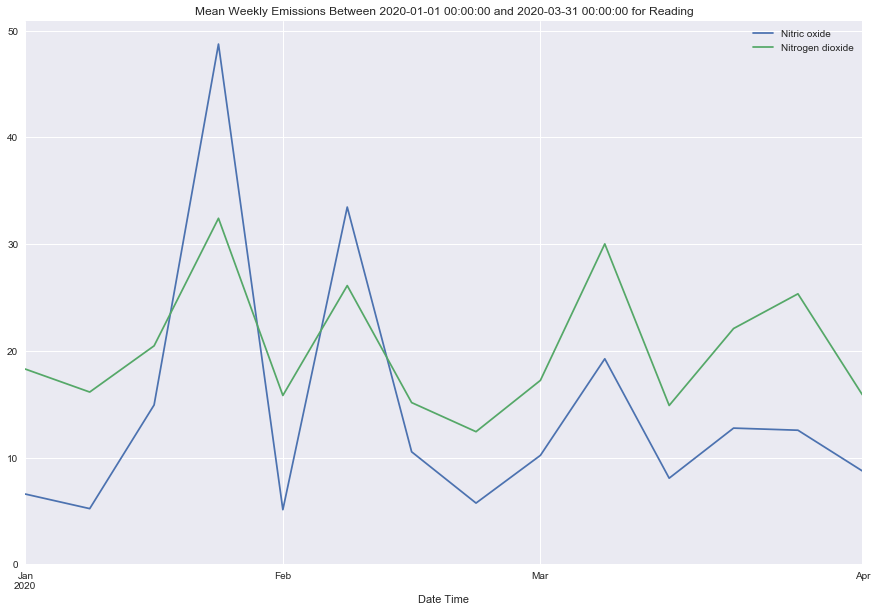

In [7]:
plot_date_range(start='2020-01-01',end='2020-03-31',resample_string='W',plottype='line',aggregate='mean')

# Rolling summary

(0, 587966.7848189999)

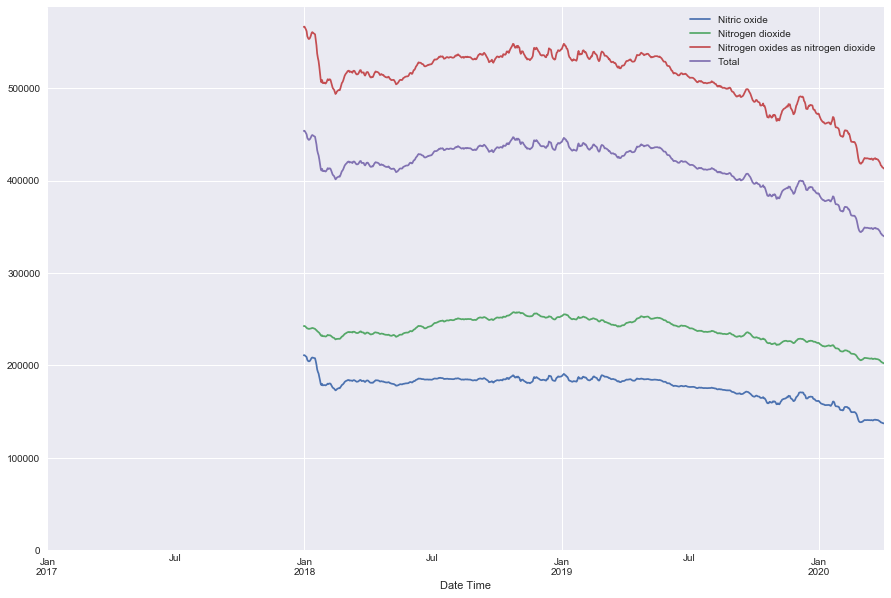

In [8]:
plt.style.use('seaborn')
ax = df_all[['Nitric oxide','Nitrogen dioxide',
              'Nitrogen oxides as nitrogen dioxide',
             'Total']].resample('D').sum().rolling(365).sum().plot(figsize=[15,10])
ax.set_ylim(0,None)


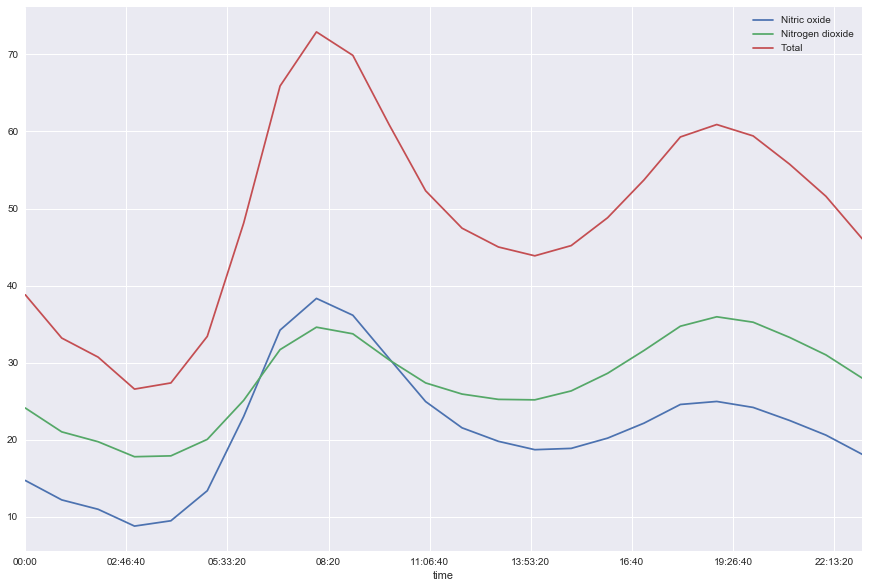

In [9]:
df_all[['Nitric oxide','Nitrogen dioxide','Total']
      ].groupby(df_all[['Nitric oxide','Nitrogen dioxide',
             'Total']].index.time).mean().plot(figsize=[15,10])

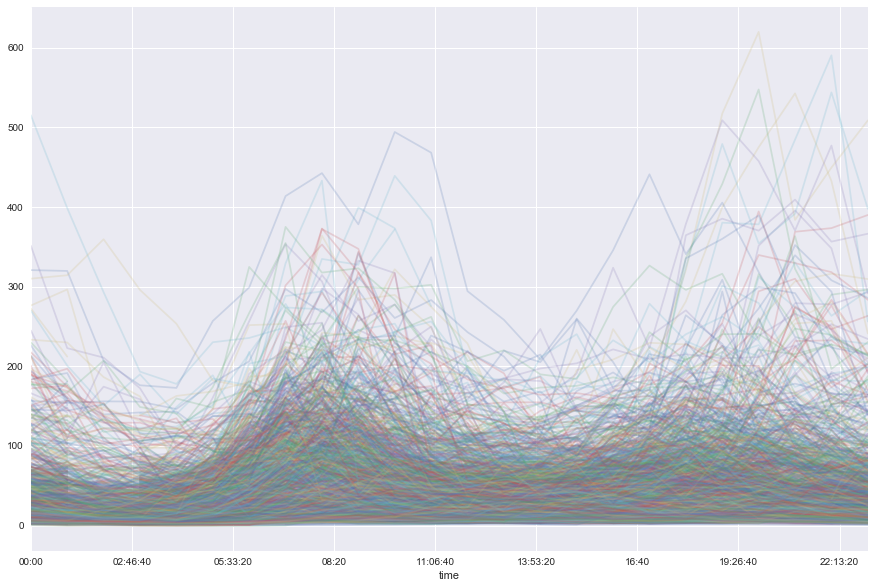

In [10]:
pivoted = df_all.pivot_table('Total',index=df_all.index.time,columns=df_all.index.date)
pivoted.plot(legend=False,alpha=0.2,figsize=[15,10])

# Comparing multiple years on one plot

In [11]:
# Note - only really works for hourly and daily, although daily is only one that's useful 
def year_comparison(start,end,resample_string,years_of_data):
    global df_2020, df_2019, df_2018, df_2017
    '''
    Parameters:
    start = string of date in format 'MM-DD'
    end = string of date in format 'MM-DD'
    resample_string = 'H','D','W','M'
    years_of_data = 1, 2, 3 or 4, determines how many years to plot
    '''
   
    # below is hideous but I'm just doing it in this dumb way because I know it'll work
    # gets you start and end dates for each year
    start_2020 = '2020-' + start
    start_2020 = pd.to_datetime(start_2020)
    end_2020 = '2020-' + end
    end_2020 = pd.to_datetime(end_2020)
    
    start_2019 = '2019-' + start
    start_2019 = pd.to_datetime(start_2019)
    end_2019 = '2019-' + end
    end_2019 = pd.to_datetime(end_2019)
       
    start_2018 = '2018-' + start
    start_2018 = pd.to_datetime(start_2018)
    end_2018 = '2018-' + end
    end_2018 = pd.to_datetime(end_2018)
    
    start_2017 = '2017-' + start
    start_2017 = pd.to_datetime(start_2017)
    end_2017 = '2017-' + end
    end_2017 = pd.to_datetime(end_2017)
    
    ### MASKS ###
    # 2020
    mask = (df_2020['Date Time'] >= start_2020) & (df_2020['Date Time'] <= end_2020) # REPLACE MASKS WITH .LOC!
    df_2020_ = df_2020.loc[mask]
    # 2019
    mask = (df_2019['Date Time'] >= start_2019) & (df_2019['Date Time'] <= end_2019) # REPLACE MASKS WITH .LOC!
    df_2019_ = df_2019.loc[mask]
    # 2018
    mask = (df_2018['Date Time'] >= start_2018) & (df_2018['Date Time'] <= end_2018) # REPLACE MASKS WITH .LOC!
    df_2018_ = df_2018.loc[mask]
    # 2017
    mask = (df_2017['Date Time'] >= start_2017) & (df_2017['Date Time'] <= end_2017) # REPLACE MASKS WITH .LOC!
    df_2017_ = df_2017.loc[mask]
    
    if resample_string=='H':
        ### Making date time no year column
        df_2020_['Date Time No Year'] = df_2020_['Date Time'].dt.strftime('%m-%d %H:%M')
        df_2019_['Date Time No Year'] = df_2019_['Date Time'].dt.strftime('%m-%d %H:%M')
        df_2018_['Date Time No Year'] = df_2018_['Date Time'].dt.strftime('%m-%d %H:%M')
        df_2017_['Date Time No Year'] = df_2017_['Date Time'].dt.strftime('%m-%d %H:%M')

        ### Plotting them with date time no year
        plt.figure(figsize=(15,10))
        
        if years_of_data==4:
            sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Nitric oxide'],
                        label = '2020 Nitric Oxide',linestyle='-',marker='o',alpha=1,color='#2C497F')
            sns.lineplot(x=df_2019_['Date Time No Year'],y=df_2019_['Nitric oxide'],
                        label = '2019 Nitric Oxide',linestyle=':',alpha=0.6,color='#775253')
            sns.lineplot(x=df_2018_['Date Time No Year'],y=df_2018_['Nitric oxide'],
                        label = '2018 Nitric Oxide',alpha=0.6,linestyle=':',color='#FF9914')
            sns.lineplot(x=df_2017_['Date Time No Year'],y=df_2017_['Nitric oxide'],
                        label ='2017 Nitrix Oxide',alpha=0.6,linestyle='-.',color='#EC4E20')
        
        elif years_of_data==3:
            sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Nitric oxide'],
                    label = '2020 Nitric Oxide',linestyle='-',marker='o',alpha=1,color='#2C497F')
            sns.lineplot(x=df_2019_['Date Time No Year'],y=df_2019_['Nitric oxide'],
                        label = '2019 Nitric Oxide',linestyle=':',alpha=0.6,color='#775253')
            sns.lineplot(x=df_2018_['Date Time No Year'],y=df_2018_['Nitric oxide'],
                        label = '2018 Nitric Oxide',alpha=0.6,linestyle=':',color='#FF9914')
    
        elif years_of_data==2:
            sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Nitric oxide'],
                    label = '2020 Nitric Oxide',linestyle='-',marker='o',alpha=1,color='#2C497F')
            sns.lineplot(x=df_2019_['Date Time No Year'],y=df_2019_['Nitric oxide'],
                        label = '2019 Nitric Oxide',linestyle=':',alpha=0.6,color='#775253')
            
        elif years_of_data==1:
            sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Nitric oxide'],
                    label = '2020 Nitric Oxide',linestyle='-',marker='o',alpha=1,color='#2C497F')
    
        plt.xticks(rotation=90) # would be great to strip the hours from the x ticks
        plt.xlabel('')
        plt.ylabel('Nitric oxide (ugm$^3$)')
        plt.title('Hourly Total Nitric Oxide Emmisions From Date {} to {} of Each Year'.format(start,end))
        plt.legend(loc='upper center')
        plt.xticks('')
    
    elif resample_string!='H':
        ### Resample accordingly (however only by day works)
        plt.figure(figsize=(15,10))
        df_2020_ = df_2020_.resample(resample_string).sum()
        df_2019_ = df_2019_.resample(resample_string).sum()
        df_2018_ = df_2018_.resample(resample_string).sum()
        df_2017_ = df_2017_.resample(resample_string).sum()
                
        ### Making date time no year column
        df_2020_['Date Time No Year'] = df_2020_.index.strftime('%m-%d %H:%M')
        df_2019_['Date Time No Year'] = df_2019_.index.strftime('%m-%d %H:%M')
        df_2018_['Date Time No Year'] = df_2018_.index.strftime('%m-%d %H:%M')
        df_2017_['Date Time No Year'] = df_2017_.index.strftime('%m-%d %H:%M')
        
        #### Replacing date time as index as removing datatime column 
        def cleaner(variable):
            variable.index = variable['Date Time No Year']

        cleaner(df_2020_)
        cleaner(df_2019_)
        cleaner(df_2018_)
        cleaner(df_2017_)

        plt.figure(figsize=(15,10))
        if years_of_data==4:
            sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Nitric oxide'],
                         label='2020 Nitric Oxide',linestyle='-',marker='o',alpha=1,color='#2C497F')
            sns.lineplot(x=df_2019_['Date Time No Year'],y=df_2019_['Nitric oxide'],
                         label='2019 Nitric Oxide',linestyle=':',alpha=0.6,color='#775253')
            sns.lineplot(x=df_2018_['Date Time No Year'],y=df_2018_['Nitric oxide'],
                         label='2018 Nitric Oxide',alpha=0.6,linestyle=':',color='#FF9914')
            sns.lineplot(x=df_2017_['Date Time No Year'],y=df_2017_['Nitric oxide'],
                         label='2017 Nitrix Oxide',alpha=0.6,linestyle='-.',color='#EC4E20')
            
        elif years_of_data==3:
            sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Nitric oxide'],
                         label='2020 Nitric Oxide',linestyle='-',marker='o',alpha=1,color='#2C497F')
            sns.lineplot(x=df_2019_['Date Time No Year'],y=df_2019_['Nitric oxide'],
                         label='2019 Nitric Oxide',linestyle=':',alpha=0.6,color='#775253')
            sns.lineplot(x=df_2018_['Date Time No Year'],y=df_2018_['Nitric oxide'],
                         label='2018 Nitric Oxide',alpha=0.6,linestyle=':',color='#FF9914')

        elif years_of_data==2:
            sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Nitric oxide'],
                         label='2020 Nitric Oxide',linestyle='-',marker='o',alpha=1,color='#2C497F')
            sns.lineplot(x=df_2019_['Date Time No Year'],y=df_2019_['Nitric oxide'],
                         label='2019 Nitric Oxide',linestyle=':',alpha=0.6,color='#775253')

        elif years_of_data==1:
            sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Nitric oxide'],
                         label='2020 Nitric Oxide',linestyle='-',marker='o',alpha=1,color='#2C497F')

        plt.xticks(rotation=90) # would be great to strip the hours from the x ticks
        plt.xlabel('')
        plt.ylabel('Nitric oxide (ugm$^3$)')
        plt.title('Daily Total Nitric Oxide Emmisions From Date {} to {} of Each Year'.format(start,end))
        plt.legend(loc='upper center')


<Figure size 1080x720 with 0 Axes>

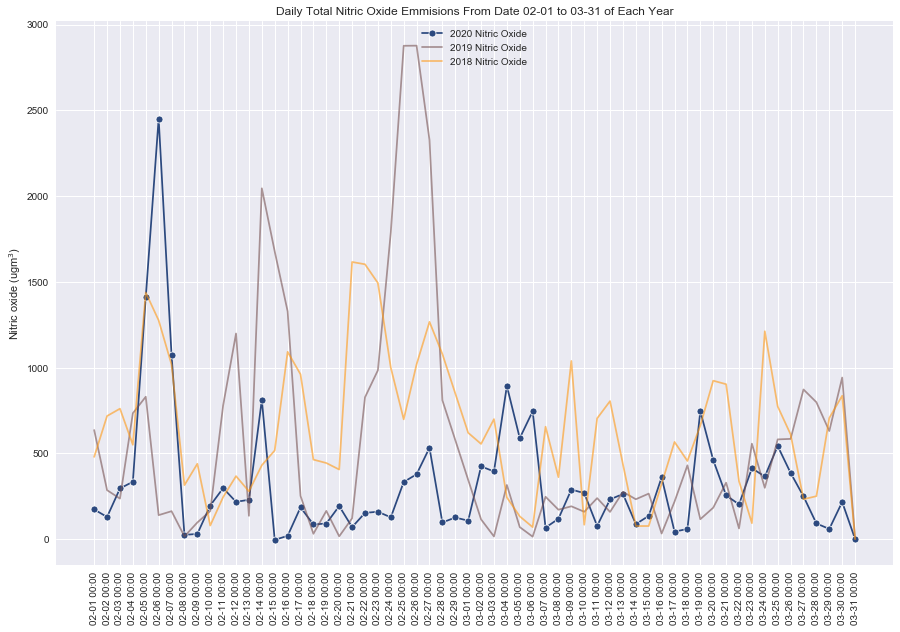

In [12]:
year_comparison(start='02-01',end='03-31',resample_string='D',years_of_data=3) 
# would be great to be able to specify what years to plot

## Next - plot each year via week number as Dan did

# Total Emmisions for 1 month of each year


In [13]:
def month_comparison(month_str,years_to_plot):
    '''
    month_str = month in two digit format i.e. March = 03
    years_to_plot = integer. If 4, plot all 4 years, if 3 plot most recent 3 years etc
    '''
    months_with_28_days=['2','02']
    months_with_31_days=['1','01','3','03','5','05','7','07','8','08','10','12']
    months_with_30_days=['4','04','6','06','9','09','11']
    
    if month_str in(months_with_28_days):
        days_in_month = 28
    elif month_str in(months_with_31_days):
        days_in_month = 31
    elif month_str in(months_with_30_days):
        days_in_month=30
        
    # getting month name for title of plot
    monthinteger = int(month_str)
    month = calendar.month_name[monthinteger]
    
    month_17 = df_all.loc['2017-{}-01'.format(month_str):'2017-{}-{}'.format(month_str,days_in_month)] 
    month_18 = df_all.loc['2018-{}-01'.format(month_str):'2018-{}-{}'.format(month_str,days_in_month)]
    month_19 = df_all.loc['2019-{}-01'.format(month_str):'2019-{}-{}'.format(month_str,days_in_month)]
    month_20 = df_all.loc['2020-{}-01'.format(month_str):'2020-{}-{}'.format(month_str,days_in_month)]

    month_17_no = month_17['Nitric oxide'].sum()
    month_17_nd = month_17['Nitrogen dioxide'].sum()

    month_18_no = month_18['Nitric oxide'].sum()
    month_18_nd = month_18['Nitrogen dioxide'].sum()

    month_19_no = month_19['Nitric oxide'].sum()
    month_19_nd = month_19['Nitrogen dioxide'].sum()

    month_20_no = month_20['Nitric oxide'].sum()
    month_20_nd = month_20['Nitrogen dioxide'].sum()

    # Making a new dataframe to plot
    data = {'{}-2017'.format(month_str):[month_17_no,month_17_nd],
           '{}-2018'.format(month_str):[month_18_no, month_18_nd],
            '{}-2019'.format(month_str):[month_19_no, month_19_nd],
            '{}-2020'.format(month_str):[month_20_no, month_20_nd]}

    df = pd.DataFrame(data)
    df.index = ['Nitric Oxide','Nitrogen Dioxide']
    
    
    if years_to_plot==4:
        df_=df
    elif years_to_plot==3:
        df_=df[['{}-2018'.format(month_str),'{}-2019'.format(month_str),'{}-2020'.format(month_str)]]
    elif years_to_plot==2:
        df_=df[['{}-2019'.format(month_str),'{}-2020'.format(month_str)]]
    elif years_to_plot==1:
        df_=df[['{}-2020'.format(month_str)]]
    
    #plt.style.use('seaborn-poster')
    plt.style.use('tableau-colorblind10')
    df_.plot.bar(figsize=[15,10])
    plt.title('Total Emissions In {} of Each Year'.format(month))

    plt.ylabel('Total Emissions Measured (ugm$^3$)')
    plt.xticks(rotation=0)
    plt.legend(loc='upper left')

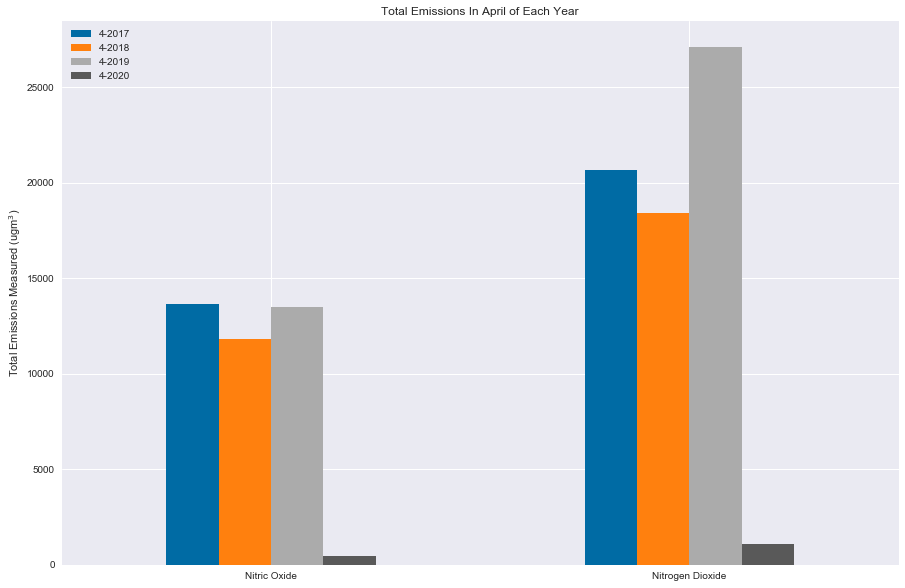

In [14]:
month_comparison(month_str='4',years_to_plot=4)

# add specifying the years to analyse too 